<a href="https://colab.research.google.com/github/arkinbhagat/DL-Project/blob/main/Bee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

First, some imports.

In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataset import Dataset

import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import os,sys
import datetime

Let us now download the dataset from Kaggle.

In [ ]:
#this downloads and extracts the dataset directly from kaggle
#you can also directly upload the zip file and it should work

!pip install kaggle 
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download deep-learning-for-msc-coursework-2022
!unzip /content/deep-learning-for-msc-coursework-2022.zip -d /content/dataset 

mkdir: cannot create directory ‘/root/.kaggle’: File exists
deep-learning-for-msc-coursework-2022.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/deep-learning-for-msc-coursework-2022.zip
replace /content/dataset/example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


These are some variables that I've declared here so I don't have to change them everytime I train the models.

In [ ]:
#this cell defines several variables such as no. of channels, no. of epochs, batch size etc

dataroot = '/content/dataset'
workers = 2
batch_size = 128
image_size = 32
nc = 3 
epochs = 10
latent_dims = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu' #checks if gpu runtime is available

This function calculates weights for the unbalanced data set.

In [ ]:
#Function to calculate the weights for the unbalanced data set

def weights_calc(images, k):                        
    count = [0] * k                                                  
    for element in images:                                                         
        count[element[1]] += 1                                                     
    weight_per_class = [0.] * k                                     
    n = float(sum(count))                                                   
    for i in range(k):                                                   
        weight_per_class[i] = n/float(count[i])                                 
    w = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        w[idx] = weight_per_class[val[1]]                                  
    return w                                                        

Finally, I load the training and test data sets using ImageFolder. I have also defined the keys for different tissue classes for later use.

In [ ]:
#i have used imagefolder to load both the training and test sets and have also converted them to torch tensors using transforms
#shuffle is kept off, because it makes getting the predictions in the correct order very tricky
#i have also used a weighted random sampler to counter the effects of the unbalanced training dataset

dataset = torchvision.datasets.ImageFolder('/content/dataset/train/train', transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

weights = weights_calc(dataset.imgs, len(dataset.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                 

data_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers, sampler = sampler)   





dataset2 = torchvision.datasets.ImageFolder('/content/dataset/test', transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))
data_test = torch.utils.data.DataLoader(dataset2, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)


#here i have split the training data into training and validation sets for future use

train_set, val_set = torch.utils.data.random_split(dataset, [1600, 100])

data_train_split = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

data_val_split = torch.utils.data.DataLoader(val_set, batch_size=10,
                                         shuffle=False, num_workers=workers)

In [ ]:
#these are the keys for each class which will be used later on for making the predictions csv file

print(dataset.class_to_idx)

class_keys = {
    3: "Normal",
    0: "Cancer",
    2: "Immune",
    1: "Connective"}

{'Cancer': 0, 'Connective': 1, 'Immune': 2, 'Normal': 3}


# Autoencoder

In this section, I have defined the Encoder, Decoder and Autoencoder.

In [ ]:
#this is a simple encoder with two linear layers 
#it essentially flattens the input and transforms it into a latent space of latent_dims

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(3072, 1024)
        self.linear2 = nn.Linear(1024, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [ ]:
#this is a simple decoder with two linear layers 
#this converts the latent space back to the original dimensions

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 1024)
        self.linear2 = nn.Linear(1024, 3072)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 32, 32))

In [ ]:
#the autoencoder contains the encoder and decoder as layers

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)        
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
#the training loop uses simple mean square loss and displays the loss at each epoch

def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    total_loss = []
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) 
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
        print (f'Train epoch:{epoch} with previous loss {loss}');
        total_loss.append(float(loss))
    plt.plot(np.arange(epochs),total_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss at Epoch")
    plt.title("Epoch vs Loss")
    return autoencoder

In [ ]:
#initialise the autoencoder and move it to the gpu, if available

autoencoder = Autoencoder(latent_dims).to(device) 

Train epoch:0 with previous loss 8463.39453125
Train epoch:1 with previous loss 7596.12548828125
Train epoch:2 with previous loss 7208.689453125
Train epoch:3 with previous loss 7189.38916015625
Train epoch:4 with previous loss 7012.48046875
Train epoch:5 with previous loss 6944.50634765625
Train epoch:6 with previous loss 6747.5341796875
Train epoch:7 with previous loss 6867.42431640625
Train epoch:8 with previous loss 7342.00146484375
Train epoch:9 with previous loss 7671.8896484375


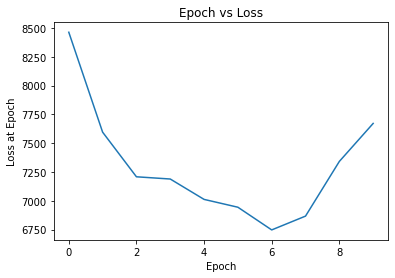

In [ ]:
#train the autoencoder on the test set (unsupervised)
#print the loss at each epoch and plot the curve

autoencoder = train(autoencoder, data_test, epochs)

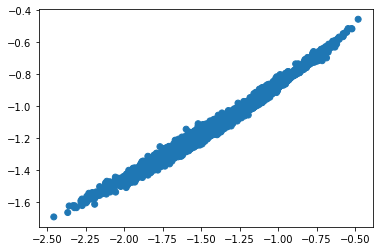

In [ ]:
#plots the first two dimensions of the latent space produced by the encoder

def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()

        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(autoencoder, data_test)

# CNN

Here I have defined the Convolutional Network and the training and testing loops.

In [ ]:
#i have used a cnn with 8 layers in total
#the network uses cross entropy loss, so I have not defined a softmax layer after the final dense layers

#the input size is (3,32,32) which becomes (1,3072) when flattened
#the output is one of four nodes (0,1,2,3) which the network predicts as the class label for the image under consideration

model = nn.Sequential(collections.OrderedDict([
          ('conv2d1', nn.Conv2d(3, 32, kernel_size=3, padding=1)),
          ('reLU1', nn.ReLU(True)),
          ('batchnorm2d1', nn.BatchNorm2d(32)),
          ('maxpool1', nn.MaxPool2d(2)),
          ('dropout1', nn.Dropout(p=0.5)),

          ('flatten', nn.Flatten()),
          ('fc1', nn.Linear(8192, 4096)),
          ('fc2', nn.Linear(4096, 4)),

        ]))


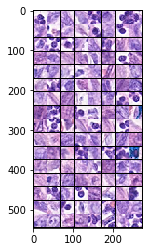

In [ ]:
#i have used the ADAM optimizer for this network
#this cell also displays a sample minibatch of images to see if the dataloader is working properly

#lr = 0.01
#opt = optim.SGD(model.parameters(), lr=lr)
opt = torch.optim.Adam(model.parameters())

images, labels = next(iter(data_train))
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')


loss_fn = nn.CrossEntropyLoss()

In [ ]:
#the training loop takes in the no. of epochs, the optimizer, the model, the device, the loss function and the training data as parameters
#it also displays the training loss at each epoch

#the test loop takes in the model, the device and the test data as parameters
#it displays the average loss over n epochs as well as the accuracy 

epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    all_loss = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            all_loss.append(loss_train)
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
    plt.plot(all_loss, label='Training loss')
    plt.title("Loss over epochs")
    plt.show()        
  

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    all = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()
            all.append(pred.cpu())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return(all)

# Predictions and Conclusions

2022-03-25 22:52:39.294348 Epoch 1, Training loss 86.33647936582565
2022-03-25 22:52:41.285889 Epoch 2, Training loss 22.454685360193253
2022-03-25 22:52:42.516280 Epoch 3, Training loss 12.222550347447395
2022-03-25 22:52:43.459018 Epoch 4, Training loss 5.039475351572037
2022-03-25 22:52:44.404463 Epoch 5, Training loss 3.808187298476696
2022-03-25 22:52:45.370817 Epoch 6, Training loss 2.850446544587612
2022-03-25 22:52:46.349237 Epoch 7, Training loss 2.784234531223774
2022-03-25 22:52:47.429790 Epoch 8, Training loss 3.9509440883994102
2022-03-25 22:52:48.899722 Epoch 9, Training loss 2.433110585436225
2022-03-25 22:52:50.406693 Epoch 10, Training loss 1.4960579010657966


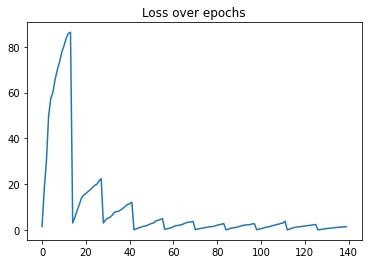

In [ ]:
#here i have trained the model on the labelled training set

training_loop(
    n_epochs = epochs, 
    optimizer = opt,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = data_train,
)

In [ ]:
#this cell loads the output predictions into a a list

predictions = test_loop(model = model, device = device, test_loader = data_test)
predictions = torch.stack(predictions).flatten().tolist()
print(predictions)


Test set: Average loss: -1.3136, Accuracy: 886/3200 (28%)

[1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 0, 1, 1, 3, 3, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 3, 0, 3, 3, 2, 1, 1, 0, 0, 3, 3, 0, 0, 3, 1, 0, 0, 0, 0, 3, 3, 1, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 2, 3, 0, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 1, 3, 0, 0, 0, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 0, 2, 3, 1, 1, 1, 1, 3, 1, 0, 1, 1, 0, 1, 1, 3, 3, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 3, 3, 1, 2, 1, 3, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 3, 1, 0, 2, 1, 1, 1, 1, 3, 2, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 0, 2, 1, 1, 1, 1, 3, 1, 3, 1, 2, 2, 1, 3, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 3, 2, 3, 2, 0, 2, 2, 1, 1, 1, 3, 1, 0, 2, 1, 3, 2, 2, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 3, 1, 1, 1, 3, 1, 2, 1, 3, 2, 1, 1, 2, 3, 1, 2, 1, 1, 0, 1, 3, 2, 1, 1, 

In [ ]:
#this cell makes a csv out of the predictions and the keys for each label
#this is the final predicted output of the network on the unlabelled test set

data = pd.DataFrame()
data["Id"] = sorted(os.listdir("/content/dataset/test/test"))
data['Type'] = list(map(lambda k: list(class_keys.values())[list(class_keys.keys()).index(k)], predictions))
data.to_csv('final_pred.csv', index=False)    

data

,Id,Type
0,tile5001.png,Connective
1,tile5002.png,Connective
2,tile5003.png,Normal
3,tile5004.png,Normal
4,tile5005.png,Normal
...,...,...
3195,tile8196.png,Normal
3196,tile8197.png,Normal
3197,tile8198.png,Normal
3198,tile8199.png,Normal
